### Step 1. 데이터 수집하기

In [3]:
!pip install summa

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'summa' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'summa'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54441 sha256=0cc5dfe2d5168131adb6ed3e1004dbe2fb7feb695419e86950af70683fe36a37
  Stored in directory: /home/jovyan/.cache/pip/wheels/70/26/84/58df5a55ebde6fd802666b6ac0b86909ecd018a2702b89d13c
Successfully built summa


In [47]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
import torch
import summa
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from collections import Counter

print(nltk.__version__)
print(torch.__version__)
print(pd.__version__)
print(version('summa'))

3.9.2
2.7.1+cu118
2.3.0
1.2.0


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
!pip install lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 68.9 MB/s eta 0:00:00


In [19]:
!pip install beautifulsoup4

In [5]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [7]:
print(data.shape)
data.sample(10)

(98401, 2)


,headlines,text
72928,Adani shares rose 9% on plans to start work on...,Shares of Adani Group surged about 9% on Monda...
42646,CCTVs turned off for Jayalalithaa's 75-day tre...,Apollo Chairman Prathap C Reddy on Thursday re...
41624,T'gana education body directs teachers to spea...,Telangana Social Welfare Residential Education...
23751,"Rahul slams PM & Nitish, calls them ashwasan, ...",Referring to the rape of girls at a shelter ho...
67920,NASA observes farthest inbound comet ever seen,NASA's Hubble Space Telescope has photographed...
69360,UP plans death penalty for illicit liquor manu...,The Uttar Pradesh government on Tuesday approv...
38707,"Trump, Kim sign agreement to completely denucl...",US President Donald Trump and North Korean lea...
39895,Afghanistan pacer breaks stump into two agains...,Afghanistan pacer Shapoor Zadran's delivery to...
79141,"Iran, Iraq sign deal to boost military coopera...",Iran and US-backed Iraq on Sunday signed an ag...
7301,We don't need higher oil prices: Trump urges O...,US President Donald Trump on Wednesday called ...


### Step 2. 데이터 전처리하기 (추상적 요약)

In [8]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [9]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [10]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [11]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [14]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [17]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [24]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [25]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [27]:
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [30]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [31]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [32]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


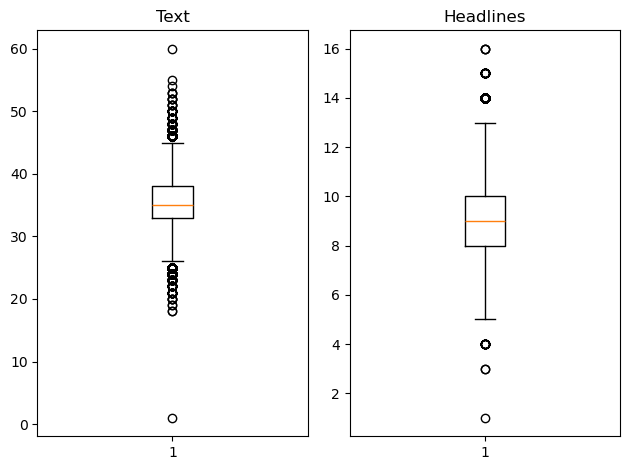

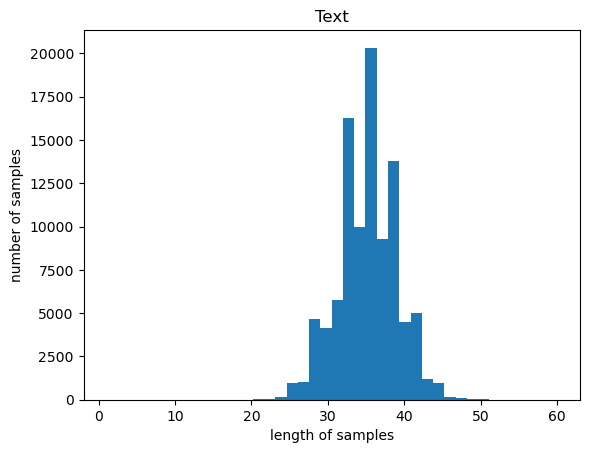

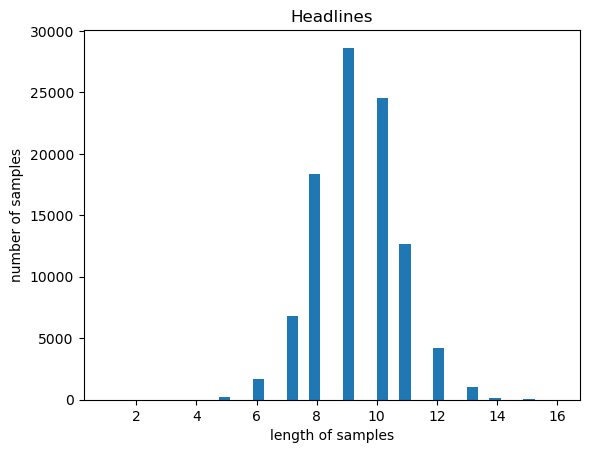

In [34]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [35]:
text_max_len = 46
headlines_max_len = 13

In [36]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [37]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 46 이하인 샘플의 비율: 0.9983021553477023
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [38]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98013


In [40]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [41]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [42]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[77502 76079 30199 ... 11014 79084 55382]


In [43]:
#섞인 인덱스로 데이터 샘플 섞음

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


In [44]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19602


In [45]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78411
훈련 레이블의 개수 : 78411
테스트 데이터의 개수 : 19602
테스트 레이블의 개수 : 19602


In [48]:
def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [49]:
threshold = 7

# 전처리된 데이터 사용
text_data = data['text'].tolist()
headlines_data = data['headlines'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 76109
등장 빈도가 6번 이하인 희귀 단어의 수: 51604
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24505
단어 집합에서 희귀 단어의 비율: 67.80275657281005
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0357118447033407


In [50]:
src_vocab_size = 22000

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)
print('=3')

=3


In [51]:
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[694, 81, 1, 5925, 348, 321, 8506, 1819, 163, 11231, 20697, 1, 7235, 2, 278, 1, 1840, 36, 8800, 15963, 331, 1, 5, 1127, 856, 1580, 694, 287, 195, 5708, 331], [1130, 2894, 6, 3826, 7987, 12925, 101, 451, 2839, 14215, 528, 25, 55, 2749, 2116, 9, 147, 2666, 26, 815, 211, 107, 6, 17, 189, 4210, 40, 1476, 1738, 242, 1079, 66, 428, 5225, 274, 6241], [881, 2436, 1, 1, 822, 2839, 243, 3642, 17440, 1, 1, 5381, 1983, 50, 4372, 3748, 1028, 1, 6048, 5381, 8507, 3748, 2392, 1012, 1, 215, 1066, 1013, 1, 319, 1205, 3848, 47, 2436, 1254, 385]]
[[18, 239, 1235, 136, 942, 108, 1, 1708, 2020, 58, 273, 177, 2200, 13, 239, 1246, 18, 13, 5230, 728, 101, 1708, 2020, 10, 2, 3943, 141, 11675, 416, 628, 76, 1982, 1839, 2], [1, 1155, 1363, 118, 1208, 932, 878, 3491, 930, 1, 417, 1270, 2661, 1662, 1, 5762, 1, 258, 4046, 2246, 14040, 828, 3, 3665, 11801, 258, 695, 1730, 1, 181, 2836, 11692, 12437, 1, 1, 1, 2661, 5708], [336, 26, 2884, 37, 13675, 183, 4273, 2727, 1588, 439, 1, 301, 4158, 593, 19, 433, 223, 666, 3,

In [52]:
def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)
print('=3')

=3


In [53]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30019
등장 빈도가 5번 이하인 희귀 단어의 수: 19631
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10388
단어 집합에서 희귀 단어의 비율: 65.3952496752057
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.663522616708911


In [54]:
tar_vocab_size = 10000
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 26, 10, 74, 2660, 83, 6773, 9141, 5, 437, 1], [2, 27, 63, 814, 1, 1228, 484, 2413, 8, 19, 5364], [2, 949, 2438, 939, 9642, 15, 6774, 7, 750, 23], [2, 1613, 376, 177, 3292, 851, 2558, 2489, 1388], [2, 46, 20, 129, 3776, 2926, 8, 997, 23, 3256, 779, 5126]]
target
decoder  [[26, 10, 74, 2660, 83, 6773, 9141, 5, 437, 1, 3], [27, 63, 814, 1, 1228, 484, 2413, 8, 19, 5364, 3], [949, 2438, 939, 9642, 15, 6774, 7, 750, 23, 3], [1613, 376, 177, 3292, 851, 2558, 2489, 1388, 3], [46, 20, 129, 3776, 2926, 8, 997, 23, 3256, 779, 5126, 3]]


In [55]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78411
훈련 레이블의 개수 : 78411
테스트 데이터의 개수 : 19602
테스트 레이블의 개수 : 19602


In [57]:
from torch.nn.utils.rnn import pad_sequence

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=headlines_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=headlines_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=headlines_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=headlines_max_len)

print('=3')

=3


### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [144]:
import torch.nn as nn
import torch.nn.functional as F

# 인코더 설계 시작
embedding_dim = 256
hidden_size = 512
src_vocab_size = len(src_vocab)  # 단어 집합 크기

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.3)

In [145]:
# 디코더 설계
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.3)

In [146]:
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

# 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)
print(model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(22000, 256)
    (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=512, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (concat): Linear(in_features=1024, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=10000, bias=True)
)


In [147]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Hyperparameters
batch_size = 32
epochs = 50
learning_rate = 0.0001
patience = 5

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [148]:
train_losses = []
val_losses = []

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

In [ ]:
%%time
# 30분 이상 시간이 걸릴 수 있습니다. GPU 환경에서 학습하는 것을 권장합니다.
# 학습 실행
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 6.7056 | Val Loss: 6.3537
Epoch 2/50 | Train Loss: 6.2135 | Val Loss: 5.9630
Epoch 3/50 | Train Loss: 5.8154 | Val Loss: 5.6430
Epoch 4/50 | Train Loss: 5.5231 | Val Loss: 5.4336
Epoch 5/50 | Train Loss: 5.2963 | Val Loss: 5.2662
Epoch 6/50 | Train Loss: 5.1019 | Val Loss: 5.1266
Epoch 7/50 | Train Loss: 4.9293 | Val Loss: 5.0079
Epoch 8/50 | Train Loss: 4.7696 | Val Loss: 4.9113
Epoch 9/50 | Train Loss: 4.6232 | Val Loss: 4.8239
Epoch 10/50 | Train Loss: 4.4879 | Val Loss: 4.7538
Epoch 11/50 | Train Loss: 4.3615 | Val Loss: 4.6911
Epoch 12/50 | Train Loss: 4.2441 | Val Loss: 4.6478
Epoch 13/50 | Train Loss: 4.1331 | Val Loss: 4.6031
Epoch 14/50 | Train Loss: 4.0276 | Val Loss: 4.5706
Epoch 15/50 | Train Loss: 3.9267 | Val Loss: 4.5446
Epoch 16/50 | Train Loss: 3.8307 | Val Loss: 4.5178
Epoch 17/50 | Train Loss: 3.7372 | Val Loss: 4.5031
Epoch 18/50 | Train Loss: 3.6489 | Val Loss: 4.4877
Epoch 19/50 | Train Loss: 3.5627 | Val Loss: 4.4783
Epoch 20/50 | Train L

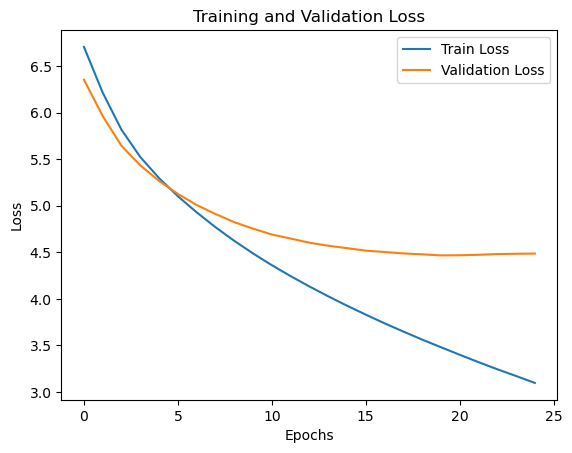

In [152]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [153]:
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

In [154]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder.to(device)

# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)

print('=3')

=3


In [155]:
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)
print('=3')

=3


In [156]:
def decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, headlines_max_len, device):
    # 입력을 PyTorch Tensor로 변환
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

    # 인코더 실행하여 초기 상태(hidden, cell) 얻기
    with torch.no_grad():
        e_out, e_h, e_c = encoder(input_seq)

    e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

    # <SOS>에 해당하는 토큰 생성
    target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 실행
        with torch.no_grad():
            output_tokens, h, c = decoder(target_seq, e_h, e_c)

        # 가장 높은 확률을 가진 단어 선택
        sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence
print("=3")

=3


In [157]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

print('=3')

=3


In [158]:
%%time
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2headlines(decoder_input_test[i]))
    input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 헤드라인 :", decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, headlines_max_len, device))
    print("\n")

원문 : islamic state sunday claimed responsibility london terror attack saying <UNK> islamic state fighters executed seven people died injured car ploughed pedestrians three terrorists armed knives stabbed people pubs restaurants attackers gunned eight minutes police alerted
실제 헤드라인 : islamic state claims responsibility for london terror attack
예측 헤드라인 :  reports without fb female wc are do do record while modi sena


원문 : couple uttar pradesh moradabad allegedly killed year old <UNK> daughter tantrik advised next child would healthy bury victim grandmother claimed mother buried house planned build shrine spot body recovered june police arrested anyone yet
실제 헤드라인 : parents kill kid on tantrik advice bury body inside home
예측 헤드라인 :  just cr google offers against wc is attack tech minister same being


원문 : bcci executive reportedly said indian captain virat kohli pacer jasprit bumrah rested indian premier league ahead world cup kohli spent time middle bowler would resting bowling four ov

<timed exec>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_87/1642412709.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


예측 헤드라인 :  centre use chief held are visit black under while released black while


원문 : twinkle khanna twitter denied reports upset team akshay kumar starrer film padman reports suggested twinkle also film producer upset production team could keep budget check due owes money creditors film also stars radhika apte sonam kapoor
실제 헤드라인 : twinkle denies being upset with padman team over budget
예측 헤드라인 :  mother used visit sets sets visit polls polls people un un child


원문 : speaking priorities marriage actress priyanka chopra said newly weds really turn get whatever want would tell brides whatever priority right added priority work right priority honeymoon right actress said
실제 헤드라인 : as newly <UNK> it is your turn to do what you want
예측 헤드라인 :  <UNK> <UNK> leader temple temple temple temple temple temple temple temple temple


원문 : actor ajay devgn shared picture wife kajol daughter nysa beach vacation maldives kajol nysa seen wearing <UNK> photo captioned vitamin family earlier kajol 